# 基于PaddlePaddle的A股预测

> 本项目尝试通过百度自研PaddlePaddle框架实现深度神经网络DNN和长短期记忆网络LSTM来对A股进行预测，使用数据为2000-2021年上证指数的数据

本项目[Github仓库](https://github.com/chaoers/stock-prediction)

## 运行环境

In [74]:
! pip install statsmodels arch

Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 807 kB 16.2 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 32.1 MB/s eta 0:00:01
  Attempting uninstall: cython
    Found existing installation: Cython 0.29
    Uninstalling Cython-0.29:
      Successfully uninstalled Cython-0.29
You should consider upgrading via the '/opt/conda/envs/python35-paddle120-env/bin/python -m pip install --upgrade pip' command.


In [75]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import paddle
import paddle.fluid as fluid
import paddle.fluid.layers as layers

import statsmodels.api as sm 
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.arima_model import ARIMA
import math
import arch

### GPU(CPU)调用

In [8]:
# place = fluid.CUDAPlace(0) # GPU环境用这个
place = fluid.CPUPlace() # CPU环境用这个

## 数据清洗

### 导入数据

In [9]:
data_pd = pd.read_csv('./data/data72449/shangzheng.csv')

### 查看数据头部

In [10]:
data_pd.head()
# data_pd.tail()
# data_pd.describe()
# data_pd.info()

,date,over,begin,high,low,trade,wave
0,2000年1月4日,1406.37,1368.69,1407.52,1361.21,437.09M,2.91%
1,2000年1月5日,1409.68,1407.83,1433.78,1398.32,688.09M,0.24%
2,2000年1月6日,1463.94,1406.04,1463.95,1400.25,809.05M,3.85%
3,2000年1月7日,1516.60,1477.15,1522.83,1477.15,1.60B,3.60%
4,2000年1月10日,1545.11,1531.71,1546.72,1506.40,1.51B,1.88%


### 异常项清洗

In [11]:
data_pd.info() # 没有异常项需要处理

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5130 entries, 0 to 5129
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    5130 non-null   object 
 1   over    5130 non-null   float64
 2   begin   5130 non-null   float64
 3   high    5130 non-null   float64
 4   low     5130 non-null   float64
 5   trade   5130 non-null   object 
 6   wave    5130 non-null   object 
dtypes: float64(4), object(3)
memory usage: 280.7+ KB


### 画图查看数据

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


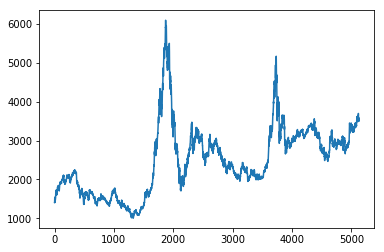

In [12]:
plt.plot(data_pd['over'])

### 提取需要数据并格式化

In [13]:
data_pd.set_index('date', inplace=True)
data_pd.drop(columns=['trade', 'wave'], inplace=True)
data_pd.head()

,over,begin,high,low
date,,,,
2000年1月4日,1406.37,1368.69,1407.52,1361.21
2000年1月5日,1409.68,1407.83,1433.78,1398.32
2000年1月6日,1463.94,1406.04,1463.95,1400.25
2000年1月7日,1516.60,1477.15,1522.83,1477.15
2000年1月10日,1545.11,1531.71,1546.72,1506.40


### 标准化数据

> 在这里只能通过训练集特征来对全部数据进行标准化，因为理论来说我们只知道当前时间之前的数据。详见[我的博客](https://www.asteriscum.cn/2021/03/03/53/21/), 所以这里就要确认数据集划分比例

In [14]:
split_boundary = int(data_pd.shape[0] * 0.8)

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(data_pd[:split_boundary])
data_transform = scaler.transform(data_pd)

# data_transform

### 建立时间滑窗，我们使用前5天数据来预测后一天的数据

In [15]:
sequence_length = 5
delay = 1
# Generated training sequences for use in the model.
def create_sequences(values, time_steps=sequence_length+delay):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

data = create_sequences(data_transform)
print("Training input shape: ", data.shape)

Training input shape:  (5124, 6, 4)


### 划分训练集和测试集

In [16]:
train = data[: split_boundary]
test = data[split_boundary:]

train.shape,test.shape

((4104, 6, 4), (1020, 6, 4))

### 建立batch生成器

In [17]:
def switch_reader(is_val: bool = False):
    def reader():
        # 判断是否是验证集
        if is_val:
            # 抽取数据使用迭代器返回
            for te in test:
                yield te[:sequence_length],te[-1:][:,0]
        else:
            # 抽取数据使用迭代器返回
            for tr in train:
                yield tr[:sequence_length],tr[-1:][:,0]#只取第0列pm2.5的值为label
        
    return reader   # 注意！此处不需要带括号

#### 测试batch生成器

In [18]:
batch_size = 128
train_reader = fluid.io.batch(reader=switch_reader(), batch_size=batch_size)
val_reader = fluid.io.batch(reader=switch_reader(is_val=True), batch_size=batch_size)
for data in train_reader():
    # print(data[0].shape,data[1].shape)
    train_x=np.array([x[0] for x in data],np.float32)
    train_y = np.array([x[1] for x in data]).astype('int64')
    print(train_x.shape,train_y.shape)

(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(8, 5, 4) (8, 1)


## DNN网络

### 定义DNN网络

In [19]:
class MyDNNModel(fluid.dygraph.Layer):
    '''
    DNN网络
    '''
    def __init__(self):
        super(MyDNNModel,self).__init__()
        self.fc1=fluid.dygraph.Linear(5*4,10,act='relu')
        self.fc2=fluid.dygraph.Linear(10,1)
        
    def forward(self,input):        # forward 定义执行实际运行时网络的执行逻辑
        '''前向计算'''
        # print('input',input.shape)
        input =fluid.layers.reshape(input,shape=[-1,5*4])
        out=self.fc1(input)
        out=self.fc2(out)
        # print(out.shape)
        return out

### 损失作图函数

In [20]:
def draw_train_loss(Batchs, train_loss,eval_loss, label=""):
    # print(len(Batchs), len(train_loss), len(eval_loss))
    plt.figure(figsize=(10, 6))
    title= label + " training-eval loss"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.plot(Batchs, train_loss, color='red', label='training loss')
    plt.plot(Batchs, eval_loss, color='g', label='eval loss')
    plt.legend()
    plt.grid()
    plt.savefig('./img/'+ label + '_loss.png', dpi=300)
    plt.show()

    # print(Batchs, train_loss)

### 开始训练

> 注：有时训练DNN会出现损失函数反常现象，这时请再次运行训练

epoch:0,batch_id:10,train_loss:[0.11340201],eval_loss:0.10979689781864484
epoch:1,batch_id:10,train_loss:[0.10834701],eval_loss:0.10497679188847542
epoch:2,batch_id:10,train_loss:[0.1034525],eval_loss:0.10027983660499255
epoch:3,batch_id:10,train_loss:[0.09868655],eval_loss:0.09569774195551872
epoch:4,batch_id:10,train_loss:[0.09405579],eval_loss:0.09124852592746417
epoch:5,batch_id:10,train_loss:[0.08956681],eval_loss:0.0869408609966437
epoch:6,batch_id:10,train_loss:[0.08522683],eval_loss:0.08277822037537892
epoch:7,batch_id:10,train_loss:[0.08103742],eval_loss:0.07876073941588402
epoch:8,batch_id:10,train_loss:[0.07699691],eval_loss:0.07488522678613663
epoch:9,batch_id:10,train_loss:[0.07310266],eval_loss:0.07114929022888343
epoch:10,batch_id:10,train_loss:[0.06935226],eval_loss:0.06755035929381847
epoch:11,batch_id:10,train_loss:[0.06574283],eval_loss:0.06408604544897874
epoch:12,batch_id:10,train_loss:[0.06227097],eval_loss:0.06075322938462099
epoch:13,batch_id:10,train_loss:[0.05

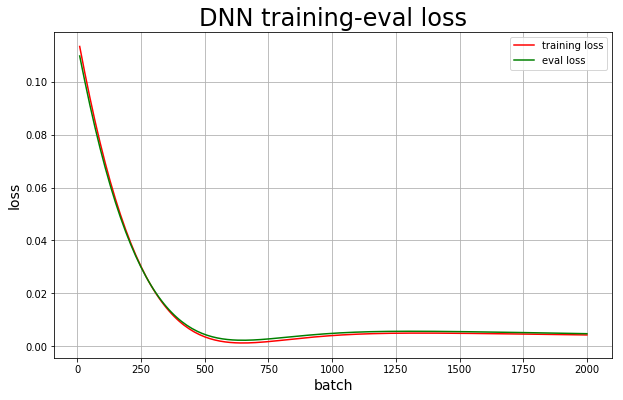

In [21]:
with fluid.dygraph.guard(place):
    model=MyDNNModel() #模型实例化
    model.train() #训练模式
    # opt=fluid.optimizer.SGDOptimizer(learning_rate=train_parameters['learning_strategy']['lr'], parameter_list=model.parameters())#优化器选用SGD随机梯度下降，学习率为0.001.
    opt=fluid.optimizer.AdamOptimizer(learning_rate=0.0001, parameter_list=model.parameters()) 
    epochs_num=200#迭代次数
    batch_size = 128 * 3
    train_reader = fluid.io.batch(reader=switch_reader(), batch_size=batch_size)
    val_reader = fluid.io.batch(reader=switch_reader(is_val=True), batch_size=batch_size)
    Batch=0
    Batchs=[]
    all_train_loss=[]
    all_eval_loss=[]
    for pass_num in range(epochs_num):
        for batch_id, data in enumerate(train_reader()): 
            data_x=np.array([x[0] for x in data],np.float32)
            data_y = np.array([x[1] for x in data]).astype('float32')
            data_x = fluid.dygraph.to_variable(data_x)
            data_y = fluid.dygraph.to_variable(data_y)
        
            # print(data_x.shape, data_y.shape)

            predict=model(data_x)
            # print(predict.shape)
            loss=fluid.layers.mse_loss(predict,data_y)
            avg_loss=fluid.layers.mean(loss)#获取loss值
            avg_loss.backward()       
            opt.minimize(avg_loss)    #优化器对象的minimize方法对参数进行更新 
            model.clear_gradients()   #model.clear_gradients()来重置梯度
            if batch_id!=0 and batch_id%10==0:
                Batch = Batch+10
                Batchs.append(Batch)
                all_train_loss.append(avg_loss.numpy()[0])
                evalavg_loss=[]
                for eval_data in val_reader():
                    eval_data_x = np.array([x[0] for x in eval_data],np.float32)
                    eval_data_y = np.array([x[1] for x in eval_data]).astype('float32')

                    eval_data_x = fluid.dygraph.to_variable(eval_data_x)
                    eval_data_y = fluid.dygraph.to_variable(eval_data_y)

                    eval_predict=model(eval_data_x)
                    eval_loss=fluid.layers.mse_loss(eval_predict,eval_data_y)
                    eval_loss=fluid.layers.mean(eval_loss)
                    evalavg_loss.append(eval_loss.numpy()[0])#获取loss值
                all_eval_loss.append(sum(evalavg_loss)/len(evalavg_loss))
        print("epoch:{},batch_id:{},train_loss:{},eval_loss:{}".format(pass_num,batch_id,avg_loss.numpy(),sum(evalavg_loss)/len(evalavg_loss)))     

    fluid.save_dygraph(model.state_dict(),'./model/MyDNNModel')#保存模型
    fluid.save_dygraph(opt.state_dict(),'./model/MyDNNModel')#保存模型
    print("Final loss: {}".format(avg_loss.numpy()))    
#绘制训练图和验证损失图，以了解训练的进行情况。     
draw_train_loss(Batchs,all_train_loss,all_eval_loss, 'DNN')

## LSTM网络

### 定义LSTM网络

In [22]:
import paddle.fluid as fluid
class MyLSTMModel(fluid.dygraph.Layer):
    '''
    LSTM网络
    '''
    def __init__(self):
        super(MyLSTMModel,self).__init__()
        self.rnn = paddle.nn.LSTM(4, 20, 2)
        self.flatten = paddle.nn.Flatten()
        self.fc1=fluid.dygraph.Linear(5*20,10)
        self.fc2=fluid.dygraph.Linear(10,1)

        
    def forward(self,input):        # forward 定义执行实际运行时网络的执行逻辑
        '''前向计算'''
        # print('input',input.shape)
        out, (h, c)=self.rnn(input)
        out =self.flatten(out)
        out=self.fc1(out)
        out=self.fc2(out)
        return out

### 开始训练

epoch:0,batch_id:10,train_loss:[0.02476512],eval_loss:0.023129687023659546
epoch:1,batch_id:10,train_loss:[0.01190875],eval_loss:0.0027992411827047667
epoch:2,batch_id:10,train_loss:[0.00578104],eval_loss:0.007348374386007587
epoch:3,batch_id:10,train_loss:[0.00204595],eval_loss:0.0005536427391537776
epoch:4,batch_id:10,train_loss:[0.00154447],eval_loss:0.0006637740686225394
epoch:5,batch_id:10,train_loss:[0.00479219],eval_loss:0.004033941503924628
epoch:6,batch_id:10,train_loss:[0.00176596],eval_loss:0.0006612322079793861
epoch:7,batch_id:10,train_loss:[0.00113699],eval_loss:0.0010525552206672728
epoch:8,batch_id:10,train_loss:[0.00096475],eval_loss:0.0005845498429456105
epoch:9,batch_id:10,train_loss:[0.00300774],eval_loss:0.002365170163102448
epoch:10,batch_id:10,train_loss:[0.00120252],eval_loss:0.0006219494583395621
epoch:11,batch_id:10,train_loss:[0.00083899],eval_loss:0.0005603440125317624
epoch:12,batch_id:10,train_loss:[0.00102286],eval_loss:0.0012319269978130858
epoch:13,batc

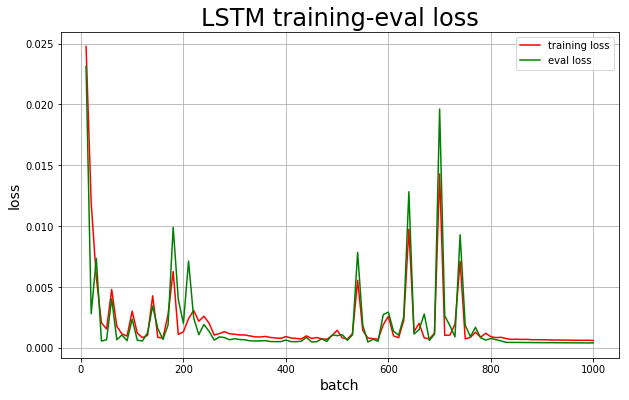

In [23]:
with fluid.dygraph.guard(place):
    model=MyLSTMModel() #模型实例化
    # model=MyModel()
    model.train() #训练模式
    # opt=fluid.optimizer.SGDOptimizer(learning_rate=0.001, parameter_list=model.parameters())#优化器选用SGD随机梯度下降，学习率为0.001.
    opt=fluid.optimizer.AdamOptimizer(learning_rate=0.01, parameter_list=model.parameters()) 
    epochs_num=100#迭代次数
    batch_size = 128*3
    train_reader = fluid.io.batch(reader=switch_reader(), batch_size=batch_size)
    val_reader = fluid.io.batch(reader=switch_reader(is_val=True), batch_size=batch_size)
    Batch=0
    Batchs=[]
    all_train_loss=[]
    all_eval_loss=[]
    for pass_num in range(epochs_num):
        for batch_id, data in enumerate(train_reader()): 
            data_x=np.array([x[0] for x in data],np.float32)
            data_y = np.array([x[1] for x in data]).astype('float32')
            data_x = fluid.dygraph.to_variable(data_x)
            data_y = fluid.dygraph.to_variable(data_y)
        
            # print(data_x.shape, data_y.shape)

            predict=model(data_x)
            # print(predict.shape)
            loss=fluid.layers.mse_loss(predict,data_y)
            avg_loss=fluid.layers.mean(loss)#获取loss值
            avg_loss.backward()       
            opt.minimize(avg_loss)    #优化器对象的minimize方法对参数进行更新 
            model.clear_gradients()   #model.clear_gradients()来重置梯度
            if batch_id!=0 and batch_id%10==0:
                Batch = Batch+10
                Batchs.append(Batch)
                all_train_loss.append(avg_loss.numpy()[0])
                evalavg_loss=[]
                for eval_data in val_reader():
                    eval_data_x = np.array([x[0] for x in eval_data],np.float32)
                    eval_data_y = np.array([x[1] for x in eval_data]).astype('float32')

                    eval_data_x = fluid.dygraph.to_variable(eval_data_x)
                    eval_data_y = fluid.dygraph.to_variable(eval_data_y)

                    eval_predict=model(eval_data_x)
                    eval_loss=fluid.layers.mse_loss(eval_predict,eval_data_y)
                    eval_loss=fluid.layers.mean(eval_loss)
                    evalavg_loss.append(eval_loss.numpy()[0])#获取loss值
                all_eval_loss.append(sum(evalavg_loss)/len(evalavg_loss))
        print("epoch:{},batch_id:{},train_loss:{},eval_loss:{}".format(pass_num,batch_id,avg_loss.numpy(),sum(evalavg_loss)/len(evalavg_loss)))     

    fluid.save_dygraph(model.state_dict(),'./model/MyLSTMModel')#保存模型
    fluid.save_dygraph(opt.state_dict(),'./model/MyLSTMModel')#保存模型
    print("Final loss: {}".format(avg_loss.numpy()))    
#让我们绘制训练图和验证损失图，以了解训练的进行情况。     
draw_train_loss(Batchs,all_train_loss,all_eval_loss, 'LSTM')

## ARIMA

### 从数据图可知，该数据不是平稳数据。 这里选择取对数的方式进行处理。

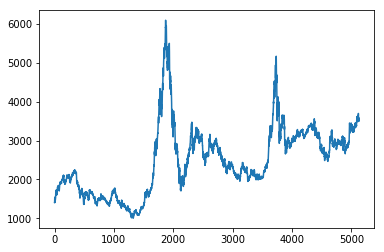

In [39]:

# data_arma = np.log(data_pd['over'].values)
data_arma = data_pd['over'].values
# data_arma_diff = data_arma
# data_arma_diff = np.diff(data_arma)[1:]
# data_arma_diff = data_pd['over'].values
# data_arma_diff = np.diff(data_pd['over'].values)[1:]


plt.plot(data_arma)

### 进行ADF检验,即使在10%的水平上也不能拒绝原假设，即序列不平稳，存在单位根

In [41]:
# ADF检验，验证是否为平稳数据
print('数据ADF检验：',sm.tsa.stattools.adfuller(data_arma))

数据ADF检验： (-2.04614080742685, 0.2667153375856042, 32, 5097, {'1%': -3.431633617101692, '5%': -2.862107222331948, '10%': -2.5670719327267992}, 53183.61330543149)


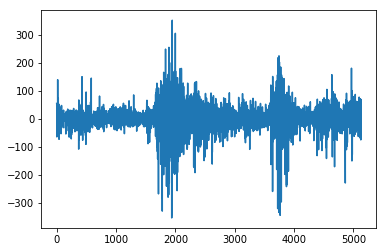

In [42]:
data_arma_diff = np.diff(data_arma)[1:]

plt.plot(data_arma_diff)

In [43]:
# ADF检验，验证是否为平稳数据
print('数据ADF检验：',sm.tsa.stattools.adfuller(data_arma_diff))

数据ADF检验： (-11.867048399521366, 6.637551809333625e-22, 33, 5094, {'1%': -3.431634373441392, '5%': -2.8621075564815404, '10%': -2.5670721106071963}, 53160.13384388323)


### 进行ADF检验,拒绝了原假设，即差分后序列平稳。但从上图中看出可能存在条件异方差，故可能要用ARCH\GARCH模型进行估计。以下先用ARMA对数据进行拟合，再根据残差的情况决定GARCH的阶数

### 自相关图截尾 q=1

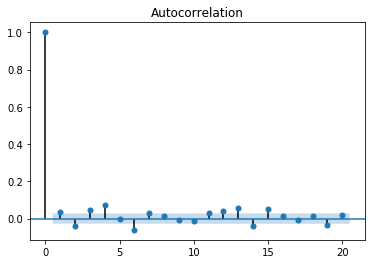

In [44]:
# 画自相关图
fig = sm.graphics.tsa.plot_acf(data_arma_diff,lags=20)

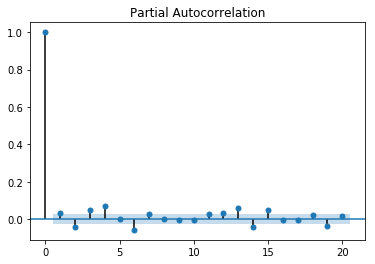

In [45]:
# 画偏自相关图
fig = sm.graphics.tsa.plot_pacf(data_arma_diff,lags=20)

In [65]:
# ARIMA（p,1,q）模型选择
# p可选4,6；q可选0，1


# ARIMA（4,1,0）模型
arima_mod44 = sm.tsa.arima.ARIMA(data_arma_diff,order=(4,1,0)).fit()
print(arima_mod44.aic,arima_mod44.bic,arima_mod44.hqic)

# ARIMA（4,1,1）模型
arima_mod46 = sm.tsa.arima.ARIMA(data_arma_diff,order=(4,1,1)).fit()
print(arima_mod46.aic,arima_mod46.bic,arima_mod46.hqic)

# ARIMA（6,1,0）模型
arima_mod64 = sm.tsa.arima.ARIMA(data_arma_diff,order=(6,1,0)).fit()
print(arima_mod64.aic,arima_mod64.bic,arima_mod64.hqic)

# ARIMA（6,1,1）模型
arima_mod66 = sm.tsa.arima.ARIMA(data_arma_diff,order=(6,1,1)).fit()
print(arima_mod66.aic,arima_mod66.bic,arima_mod66.hqic)

# 根据AIC、BIC、HQIC最小选择ARIMA（6,1,0）

54373.59481066247 54406.30619052139 54385.04508545776
53571.4414729961 53610.6951288268 53585.18180275044
54191.78849253015 54237.584424332636 54207.818877243546
53558.44047029911 53610.77867807338 53576.76090997156


1.99573833322835


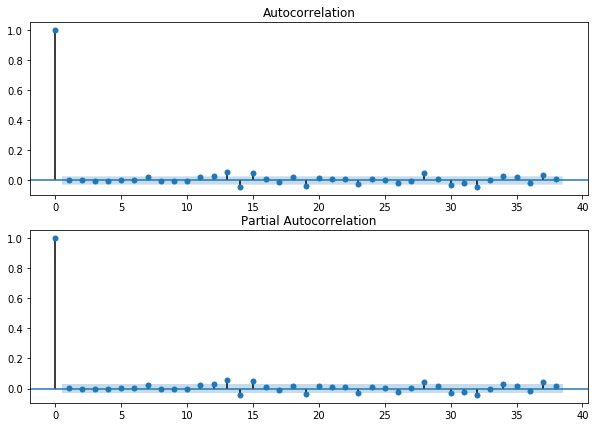

In [67]:
# 模型检验,检验残差序列
arima_mod=arima_mod66
resid = arima_mod.resid
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid,ax=ax2)
print(sm.stats.durbin_watson(arima_mod.resid))

### 从AC、PAC及durbin watson检验中发现ARIAM(6,1,0)残差平稳，较好的拟合了数据。下判断是否需要用GARCH及GARCH阶数

1.99573833322835


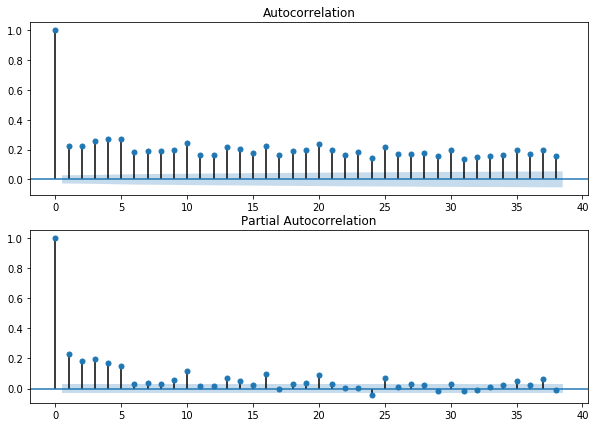

In [69]:
# 模型检验,检验残差平方序列
arima_mod=arima_mod66
resid = arima_mod.resid ** 2
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid,ax=ax2)
print(sm.stats.durbin_watson(arima_mod.resid))

### 可以看出残差是white noise process，但残差平方不是white noise process， 也即存在条件异方差，故需要用GARCH、ARCH模型进行估计

In [108]:
am = arch.arch_model(data_arma_diff ,mean='AR',lags=6 ,vol='GARCH',p=5, q=5) 
res = am.fit()
bm = arch.arch_model(data_arma_diff ,mean='AR',lags=6 ,vol='GARCH',p=10, q=10) 
res1 = bm.fit()

Iteration:      1,   Func. Count:     20,   Neg. LLF: 24963.84732146195
Iteration:      2,   Func. Count:     44,   Neg. LLF: 24953.057457820454
Iteration:      3,   Func. Count:     67,   Neg. LLF: 24952.1126356257
Iteration:      4,   Func. Count:     89,   Neg. LLF: 24946.744239096057
Iteration:      5,   Func. Count:    112,   Neg. LLF: 24945.793966014273
Iteration:      6,   Func. Count:    135,   Neg. LLF: 24944.705297421886
Iteration:      7,   Func. Count:    157,   Neg. LLF: 24936.749839517604
Iteration:      8,   Func. Count:    180,   Neg. LLF: 24935.680353468106
Iteration:      9,   Func. Count:    201,   Neg. LLF: 24931.287336890713
Iteration:     10,   Func. Count:    223,   Neg. LLF: 24929.471473259808
Iteration:     11,   Func. Count:    244,   Neg. LLF: 24926.87301432819
Iteration:     12,   Func. Count:    266,   Neg. LLF: 24926.240820181963
Iteration:     13,   Func. Count:    287,   Neg. LLF: 24923.438741234408
Iteration:     14,   Func. Count:    309,   Neg. LLF: 2

In [109]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                      y   R-squared:                       0.009
Mean Model:                        AR   Adj. R-squared:                  0.008
Vol Model:                      GARCH   Log-Likelihood:               -24909.0
Distribution:                  Normal   AIC:                           49854.0
Method:            Maximum Likelihood   BIC:                           49971.8
                                        No. Observations:                 5122
Date:                Fri, Apr 30 2021   Df Residuals:                     5115
Time:                        14:55:07   Df Model:                            7
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const          0.4067      0.373      1.090      0.276       [ -0.325,  1.138]
y[1]           0.0210  1.617e-02      1.299      0.194  [-1.069e-02,5.269e-02]
y[2]          -0.0139  1.608e-02     -0.866      0.386  [-4.544e-02,1.759e-02]
y[3]           0.0326  1.579e-02      2.067  3.874e-02   [1.689e-03,6.358e-02]
y[4]       8.8470e-03  1.705e-02      0.519      0.604  [-2.456e-02,4.226e-02]
y[5]          -0.0107  1.600e-02     -0.668      0.504  [-4.204e-02,2.067e-02]
y[6]          -0.0500  1.537e-02     -3.254  1.136e-03 [-8.016e-02,-1.990e-02]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega         25.0806      8.693      2.885  3.911e-03    [  8.043, 42.118]
alpha[1]       0.0778  2.797e-02      2.783  5.392e-03  [2.301e-02,  0.133]
alpha[2]       0.0833  2.816e-02      2.956  3.116e-03  [2.806e-02,  0.138]
alpha[3]       0.0529  3.559e-02      1.487      0.137 [-1.685e-02,  0.123]
alpha[4]       0.0471  4.299e-02      1.095      0.274 [-3.719e-02,  0.131]
alpha[5]       0.0812  2.186e-02      3.716  2.020e-04  [3.840e-02,  0.124]
beta[1]    4.6458e-15      0.127  3.672e-14      1.000    [ -0.248,  0.248]
beta[2]    5.9239e-16      0.138  4.305e-15      1.000    [ -0.270,  0.270]
beta[3]    2.4385e-15      0.168  1.450e-14      1.000    [ -0.330,  0.330]
beta[4]    1.7422e-15      0.198  8.786e-15      1.000    [ -0.389,  0.389]
beta[5]        0.6577  9.498e-02      6.924  4.382e-12    [  0.472,  0.844]
===========================================================================

Covariance estimator: robust
"""

In [110]:
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                      y   R-squared:                       0.008
Mean Model:                        AR   Adj. R-squared:                  0.007
Vol Model:                      GARCH   Log-Likelihood:               -24900.1
Distribution:                  Normal   AIC:                           49856.2
Method:            Maximum Likelihood   BIC:                           50039.3
                                        No. Observations:                 5122
Date:                Fri, Apr 30 2021   Df Residuals:                     5115
Time:                        14:55:08   Df Model:                            7
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const          0.3371      0.668      0.505      0.614       [ -0.972,  1.646]
y[1]           0.0183  2.228e-02      0.820      0.412  [-2.539e-02,6.195e-02]
y[2]          -0.0142  1.610e-02     -0.882      0.378  [-4.576e-02,1.735e-02]
y[3]           0.0284  2.264e-02      1.255      0.209  [-1.596e-02,7.277e-02]
y[4]       7.1731e-03  2.154e-02      0.333      0.739  [-3.504e-02,4.939e-02]
y[5]          -0.0104  1.756e-02     -0.591      0.555  [-4.480e-02,2.405e-02]
y[6]          -0.0526  1.580e-02     -3.330  8.676e-04 [-8.359e-02,-2.165e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega         36.2129     43.575      0.831      0.406 [-49.192,1.216e+02]
alpha[1]       0.0907  4.509e-02      2.013  4.415e-02 [2.376e-03,  0.179]
alpha[2]       0.0878      0.216      0.407      0.684   [ -0.335,  0.510]
alpha[3]       0.0683      0.208      0.328      0.743   [ -0.340,  0.476]
alpha[4]       0.0576      0.102      0.565      0.572   [ -0.142,  0.257]
alpha[5]       0.0507      0.242      0.209      0.834   [ -0.425,  0.526]
alpha[6]       0.0105      0.152  6.906e-02      0.945   [ -0.287,  0.308]
alpha[7]       0.0324      0.112      0.291      0.771   [ -0.186,  0.251]
alpha[8]   7.6984e-04      0.253  3.039e-03      0.998   [ -0.496,  0.497]
alpha[9]       0.0108  7.088e-02      0.152      0.879   [ -0.128,  0.150]
alpha[10]      0.0787      0.514      0.153      0.878   [ -0.929,  1.087]
beta[1]    1.4416e-16      1.826  7.896e-17      1.000   [ -3.578,  3.578]
beta[2]    3.3815e-17      3.071  1.101e-17      1.000   [ -6.018,  6.018]
beta[3]    1.4986e-16      1.846  8.119e-17      1.000   [ -3.618,  3.618]
beta[4]    1.1193e-16      2.266  4.939e-17      1.000   [ -4.442,  4.442]
beta[5]        0.2037      2.395  8.503e-02      0.932   [ -4.491,  4.899]
beta[6]    1.9812e-16      1.587  1.249e-16      1.000   [ -3.110,  3.110]
beta[7]    6.9466e-17      2.205  3.150e-17      1.000   [ -4.322,  4.322]
beta[8]    2.6104e-16      1.184  2.205e-16      1.000   [ -2.320,  2.320]
beta[9]    2.8166e-16      2.371  1.188e-16      1.000   [ -4.648,  4.648]
beta[10]       0.3080      1.989      0.155      0.877   [ -3.591,  4.207]
==========================================================================

Covariance estimator: robust
"""

In [218]:
data_arma = np.log(data_pd['over'].values)
arima_mod10 = sm.tsa.arima.ARIMA(data_arma,order=(1,1,0)).fit()
arima_mod=arima_mod10
train_arma = arima_mod.predict(7, data_pd.shape[0])
train_arma = math.e**(train_arma)

### 对GARCH(5,0,5) 、GARCH(10,0,10)的比较可以发现，两者的拟合后残差平方自回归的R-squre都很小，也即残差不再存在条件异方差。相比之下GARCH(5,0,5)的AIC和BIC都较小，故选择GARCH(5,0,5)作为波动率模型

In [111]:
res.params

Const       4.067343e-01
y[1]        2.100077e-02
y[2]       -1.392534e-02
y[3]        3.263518e-02
y[4]        8.846990e-03
y[5]       -1.068572e-02
y[6]       -5.002933e-02
omega       2.508061e+01
alpha[1]    7.783020e-02
alpha[2]    8.325697e-02
alpha[3]    5.291409e-02
alpha[4]    4.705620e-02
alpha[5]    8.124777e-02
beta[1]     4.645844e-15
beta[2]     5.923945e-16
beta[3]     2.438490e-15
beta[4]     1.742171e-15
beta[5]     6.576948e-01
Name: params, dtype: float64

$y_t = 0.40673 + 0.02100y_{t-1} -0.01393y_{t-2} + 0.03264y_{t-3}+0.00885y_{t-4}-0.01069y_{t-5}-0.05003y_{t-6}$

$\sigma^2_t = 0.07783 \sigma^2_{t-1} + 0.08326 \sigma^2_{t-2} + 0.05291 \sigma^2_{t-3} + 0.04706 \sigma^2_{t-4} + 0.08125 \sigma^2_{t-5} + 0.65769 h_{t-5}$

## 训练结果

### 预测结果

#### 数据集还原函数

> 开始时标准化的数据需要在实际作图时还原

In [31]:
def inverse_transform(arr):
    zero_arr = np.zeros((arr.shape[0], 3))
    zero_data = np.hstack((arr, zero_arr))
    # print(zero_data)
    zero_data = scaler.inverse_transform(zero_data)
    # print(zero_data)
    
    return zero_data[:, 0]


#### 训练集数据预测结果

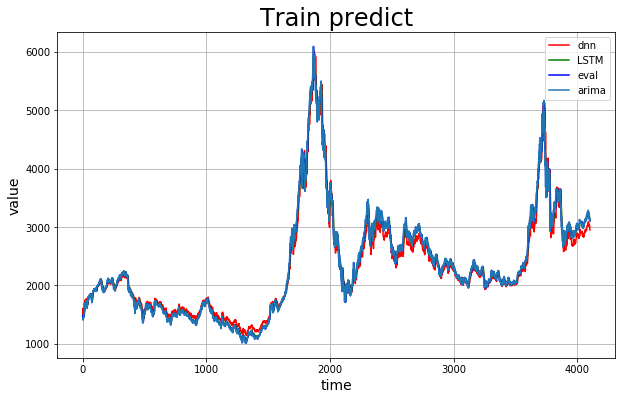

In [219]:
with fluid.dygraph.guard(place):
    accs = []
    dnn_predict = []
    model_lstm_dict, _ = fluid.load_dygraph('./model/MyLSTMModel.pdopt')
    model_dnn_dict, _ = fluid.load_dygraph('./model/MyDNNModel.pdopt')
    model_lstm = MyLSTMModel()
    model_dnn = MyDNNModel()
    model_lstm.load_dict(model_lstm_dict)
    model_dnn.load_dict(model_dnn_dict) #加载模型参数

    train_reader = fluid.io.batch(reader=switch_reader(is_val=False), batch_size=train.shape[0])
    train_data_x = np.array([x[0] for x in next(train_reader())],np.float32)
    train_data_y = np.array([x[1] for x in next(train_reader())]).astype('float32')

    train_data_x = fluid.dygraph.to_variable(train_data_x)
    train_data_y = fluid.dygraph.to_variable(train_data_y)

    train_dnn=model_dnn(train_data_x)
    train_lstm=model_lstm(train_data_x)

plt.figure(figsize=(10, 6))
title="Train predict"
plt.title(title, fontsize=24)
plt.xlabel("time", fontsize=14)
plt.ylabel("value", fontsize=14)
plt.plot(range(train.shape[0]), inverse_transform(train_dnn.numpy()), color='red', label='dnn')
plt.plot(range(train.shape[0]), inverse_transform(train_lstm.numpy()), color='g', label='LSTM')
plt.plot(range(train.shape[0]), inverse_transform(train_data_y.numpy()), color='b', label='eval')
plt.plot(range(train.shape[0]), train_arma[:split_boundary], label='arima')
plt.legend()
plt.grid()
plt.savefig('./img/train_res.png', dpi=300)
plt.show()

#### 验证集预测结果

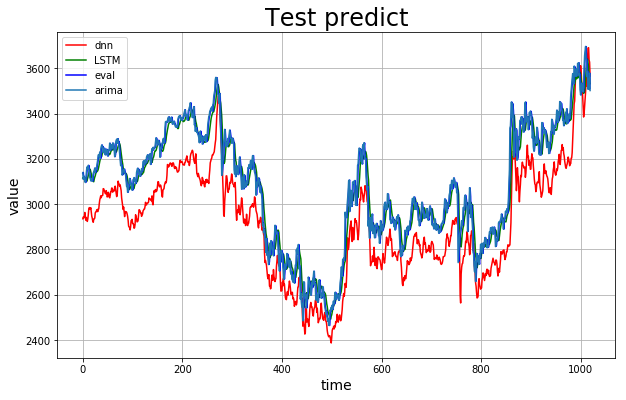

In [220]:
with fluid.dygraph.guard(place):
    accs = []
    dnn_predict = []
    model_lstm_dict, _ = fluid.load_dygraph('./model/MyLSTMModel.pdopt')
    model_dnn_dict, _ = fluid.load_dygraph('./model/MyDNNModel.pdopt')
    model_lstm = MyLSTMModel()
    model_dnn = MyDNNModel()
    model_lstm.load_dict(model_lstm_dict)
    model_dnn.load_dict(model_dnn_dict) #加载模型参数

    val_reader = fluid.io.batch(reader=switch_reader(is_val=True), batch_size=test.shape[0])
    # print(len(next(val_reader())))
    eval_data_x = np.array([x[0] for x in next(val_reader())],np.float32)
    eval_data_y = np.array([x[1] for x in next(val_reader())]).astype('float32')

    eval_data_x = fluid.dygraph.to_variable(eval_data_x)
    eval_data_y = fluid.dygraph.to_variable(eval_data_y)

    eval_dnn=model_dnn(eval_data_x)
    eval_lstm=model_lstm(eval_data_x)

plt.figure(figsize=(10, 6))
title="Test predict"
plt.title(title, fontsize=24)
plt.xlabel("time", fontsize=14)
plt.ylabel("value", fontsize=14)
plt.plot(range(test.shape[0]), inverse_transform(eval_dnn.numpy()), color='red', label='dnn')
plt.plot(range(test.shape[0]), inverse_transform(eval_lstm.numpy()), color='g', label='LSTM')
plt.plot(range(test.shape[0]), inverse_transform(eval_data_y.numpy()), color='b', label='eval')
plt.plot(range(test.shape[0]), train_arma[split_boundary:], label='arima')
plt.legend()
plt.grid()
plt.savefig('./img/test_res.png', dpi=300)
plt.show()


## 模型改进

- 神经网络模型每次训练结果具有差异性(LSTM稳定性较好一点，DNN稳定性较差)，预测结果不理想时可以尝试再次训练
- 同时模型结构未做很多尝试，在训练过程中尝试改变模型参数(模型层数，节点数量等)发现预测效果好上不少，应该还有很大的提升空间，小伙伴们可以尝试一下
- GARCH模型的其他阶数也可以进行更多的尝试

## 关于作者

### Xiyan Li

> 西安交通大学 金禾经济研究中心 本科在读

- Mail: [qq2542725243@stu.xjtu.edu.cn](mailto:qq2542725243@stu.xjtu.edu.cn)

### Asterisk(Fan Guofan)

> 西安交通大学 生物技术(生物信息学方向) 本科在读

- Mail: [fanguofan@asteriscum.cn](mailto:fanguofan@asteriscum.cn)